In [1]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from Parser import parse_frames
from scipy.signal import medfilt
from Functions import analyse_each_rep, find_extremas, filter_extremas, numpy_fillna, DTWDistance
from JointAngles import JointAngles
import numpy as np
import glob
import os
import pickle
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt


In [6]:
input_folder = "C:\\Users\\altaok\\Documents\\GitHub\\IndividualProject\\keypoints_for_all\\triceps_pushdown"
#input_folder = 'C:\\Users\\ak5u16\\Desktop\\IndividualProject\\keypoints_for_all\\triceps_pushdown'
folder_paths = glob.glob(os.path.join(input_folder, 'triceps_pushdown*'))
points_folder_name = os.path.basename(input_folder)


def get_data_for_dataset(folder_paths, points_folder_name):
    angle_label_dict = {}
    data = {}
    # need to have a dict with keys : uf_points, ut_points, tk_points; where dict[key] = [([p], 0/1)]; append(([p], 0/1))
    #labeled_arrays = {0:[()], 1:[()]}
    angle_arrays = []
    if points_folder_name == 'triceps_pushdown': 
        for folder in folder_paths:
            video_name = os.path.basename(folder)
            label = 0 if '_correct' in folder else 1
            frame_poses = parse_frames(folder)
            joint_angles = JointAngles(points_folder_name, frame_poses)


            upArm_forearm_angles = np.array(joint_angles.upArm_forearm_angles)
            upArm_forearm_angles = np.nan_to_num(upArm_forearm_angles)
            upArm_forearm_angles_filtered = medfilt(medfilt(upArm_forearm_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (upArm_forearm_angles_filtered)

            upArm_trunk_angles = np.array(joint_angles.upArm_trunk_angles)
            upArm_trunk_angles = np.nan_to_num(upArm_trunk_angles)
            upArm_trunk_angles_filtered = medfilt(medfilt(upArm_trunk_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (upArm_trunk_angles_filtered)

            trunk_knee_angles = np.array(joint_angles.trunk_knee_angles)
            trunk_knee_angles = np.nan_to_num(trunk_knee_angles)
            trunk_knee_angles_filtered = medfilt(medfilt(trunk_knee_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (trunk_knee_angles_filtered)

            #number of reps 
            upArm_forearm_minimas = filter_extremas(upArm_forearm_angles_filtered, find_extremas(upArm_forearm_angles_filtered, maxima=False), maxima=False) 

            angle_arrays.append((label, upArm_forearm_minimas, [upArm_forearm_angles_filtered, upArm_trunk_angles_filtered, trunk_knee_angles_filtered]))

    else: 
        print('Error: Wrong folder path! Has to be: triceps pushdown')

    return angle_arrays
                                             
                                    

def fill_dataframe(angle_arrays, exercise_folder_name):
    df_tup = (None,None,None)
    
    print('Filling dataset with ' + str(exercise_folder_name) + ' data...')
   
    for tup in angle_arrays:
        label = tup[0]
        extremas = tup[1]
        uf_angles, ut_angles, tk_angles = tup[2]

        # Extract rep angles
        uf_angles, ut_angles, tk_angles = analyse_each_rep('triceps_pushdown', 'dataset', extremas, uf_angles, ut_angles, tk_angles)
        s1 = pd.Series(uf_angles, name='Angle_array')
        s1a = pd.Series([label for n in range(len(uf_angles))], name='Label')
        df1 = pd.concat([s1,s1a], axis=1)
               
        s2 = pd.Series(ut_angles, name='Angle_array')
        s2a = pd.Series([label for n in range(len(ut_angles))], name='Label')
        df2 = pd.concat([s2,s2a], axis=1)
        
        s3 = pd.Series(tk_angles, name='Angle_array')
        s3a = pd.Series([label for n in range(len(tk_angles))], name='Label')
        df3 = pd.concat([s3,s3a], axis=1)
        
        df_tup = (pd.concat([df_tup[0],df1]), pd.concat([df_tup[1], df2]), pd.concat([df_tup[2],df3]))
        #pd.concat(df_list).reset_index(drop=True)

    return df_tup


        

In [51]:
#filter uf_df
def filter_uf_df(vals, df):
    idx_ls = []
    for x in vals:
        if x[:1][0] > 120 or x[-1:][0] > 120 or (x[:1][0] > 120 and x[-1:][0] > 120): 
            #print(x)
            ls_1 = df['Angle_array'].index.tolist()
            ls_2 = df['Angle_array'].values.tolist()
            hm = {}
            print(len(ls_1) == len(ls_2))           
                     
            for i, j in zip(ls_1, ls_2):
                #print(i,j)
                if np.array_equal(j,x):
                    #print(i,x)
                    idx_ls.append(i)
                    print('Deleted entry', i)
    df = df.drop(idx_ls)
        
    return df 

#filter ut_df
def filter_ut_df(vals, df):
    idx_ls = []
    for x in vals:
        if x[:1][0] > 25 or x[-1:][0] > 25 or (x[:1][0] > 25 and x[-1:][0] > 25): 
            #print(x)
            ls_1 = df['Angle_array'].index.tolist()
            ls_2 = df['Angle_array'].values.tolist()
           
            print(len(ls_1) == len(ls_2))           
                     
            for i, j in zip(ls_1, ls_2):
                #print(i,j)
                if np.array_equal(j,x):
                    #print(i,x)
                    idx_ls.append(i)
                    print('Deleted entry', i)
    df = df.drop(idx_ls)
        
    return df 

#filter tk_df
def filter_tk_df(vals, df):
    idx_ls = []
    for x in vals:
        if x[:1][0] < 140 or x[-1:][0] < 140 or (x[:1][0] < 140 and x[-1:][0] < 140): 
            #print(x)
            ls_1 = df['Angle_array'].index.tolist()
            ls_2 = df['Angle_array'].values.tolist()
            print(len(ls_1) == len(ls_2))           
                     
            for i, j in zip(ls_1, ls_2):
                #print(i,j)
                if np.array_equal(j,x):
                    print(i,x)
                    idx_ls.append(i)
                    print('Deleted entry', i)
                    
    df = df.drop(idx_ls)
        
    return df 


In [ ]:
angle_arrays = get_data_for_dataset(folder_paths, points_folder_name) 
df_tup = fill_dataframe(angle_arrays, points_folder_name)


# Filter dataframes with correct reps

In [47]:
uf_df = df_tup[0]
uf_df = uf_df[uf_df.Label == 0].reset_index(drop=True)
print(uf_df.info())
uf_df = filter_uf_df(uf_df.Angle_array.values, uf_df)
print(uf_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
Angle_array    204 non-null object
Label          204 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.3+ KB
None
True
Deleted entry 197
True
Deleted entry 198
<class 'pandas.core.frame.DataFrame'>
Int64Index: 202 entries, 0 to 203
Data columns (total 2 columns):
Angle_array    202 non-null object
Label          202 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.7+ KB
None


In [55]:
ut_df = df_tup[1]
ut_df = ut_df[ut_df.Label == 0].reset_index(drop=True)
print(ut_df.info())
ut_df = filter_ut_df(ut_df.Angle_array.values, ut_df)
print(ut_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
Angle_array    204 non-null object
Label          204 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 2 columns):
Angle_array    204 non-null object
Label          204 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.8+ KB
None


In [56]:
tk_df = df_tup[2]
tk_df = tk_df[tk_df.Label == 0].reset_index(drop=True)
print(tk_df.info())
tk_df = filter_tk_df(tk_df.Angle_array.values, tk_df)
print(tk_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
Angle_array    204 non-null object
Label          204 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 2 columns):
Angle_array    204 non-null object
Label          204 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.8+ KB
None


# Clustering


In [57]:
#correct reps dataframe
df = pd.concat([uf_df, ut_df, tk_df]).reset_index(drop=True)

In [3]:
#correct reps dataframe
df = pickle.load( open( "datasets/triceps_df.pickle", "rb" ) )

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 2 columns):
Angle_array    610 non-null object
Label          610 non-null int64
dtypes: int64(1), object(1)
memory usage: 9.7+ KB


In [90]:
series = df.Angle_array.values.tolist()

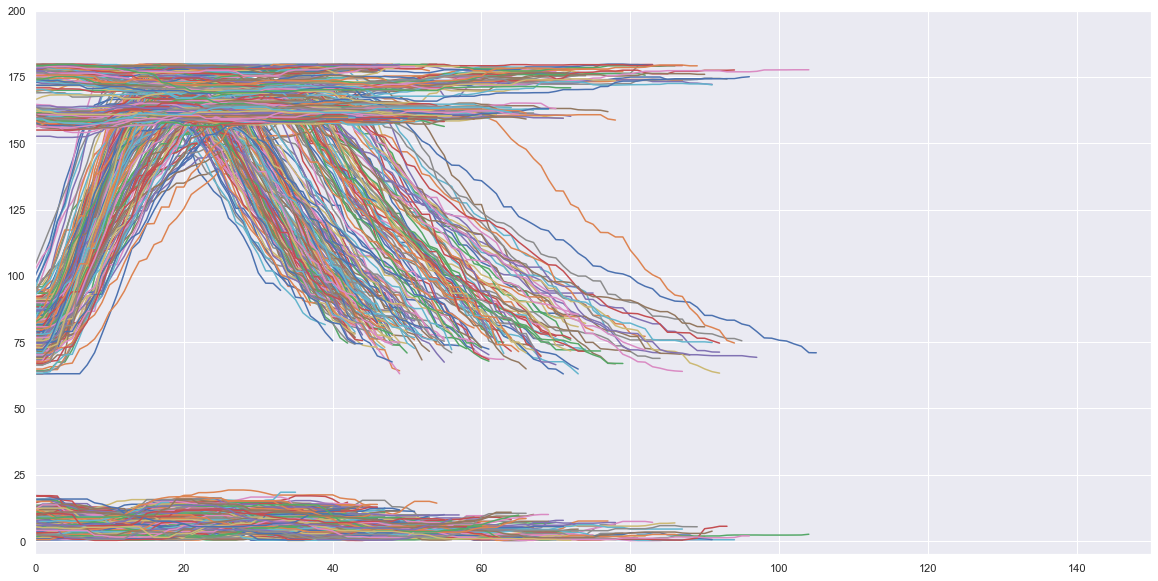

In [95]:
from dtaidistance import dtw, clustering
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance 
import seaborn as sns;sns.set()


ax = None
plt.figure(figsize=(20, 10))
plt.xlim(0, 150)
plt.ylim(-5, 200)
for ts in series:
    ax = sns.lineplot(ax=ax,data=ts, legend=False)

plt.show()


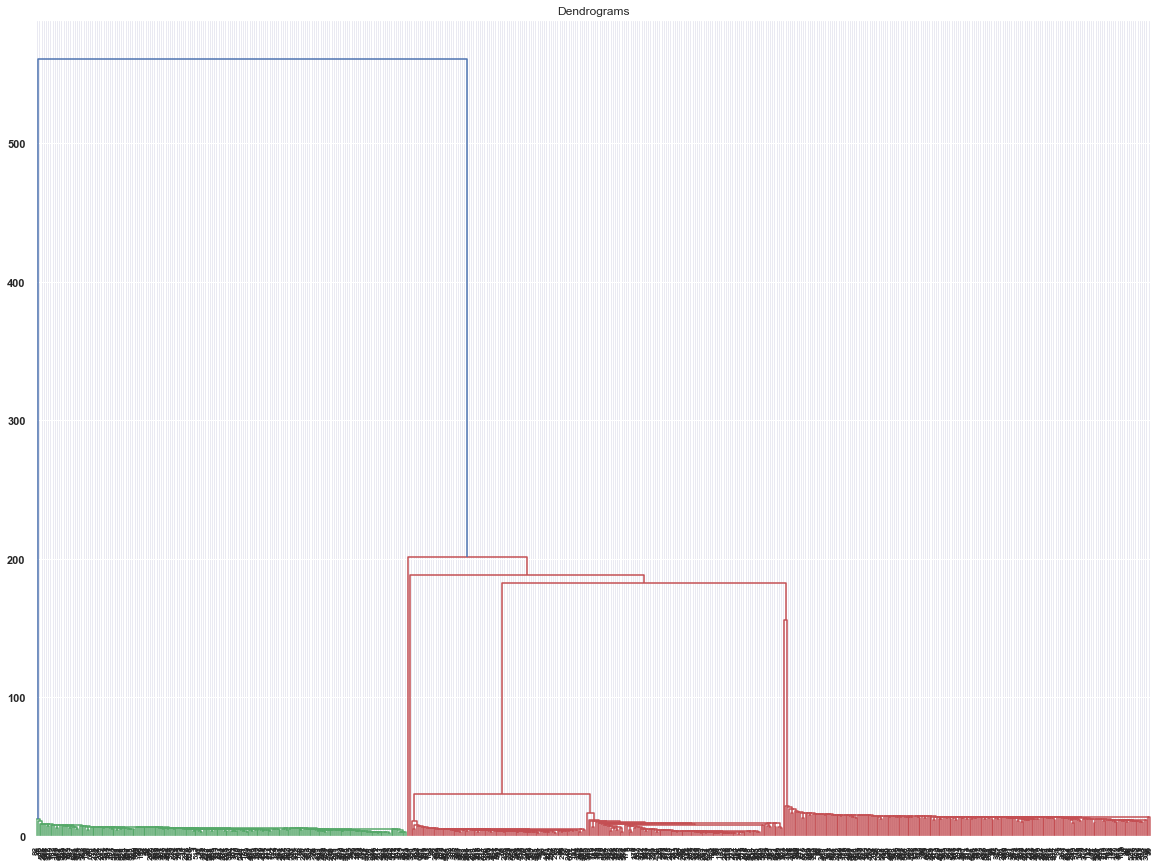

In [14]:
import scipy.cluster.hierarchy as shc
from dtaidistance import dtw, clustering
font = {'weight' : 'bold',
        'size'   : 20}
new_df = df[df['Label'] == 0]
plt.rc('font', **font)
plt.figure(figsize=(20, 15))  
plt.title("Dendrograms")  
Z = shc.linkage(numpy_fillna(new_df['Angle_array'].values),  method='single', metric=dtw.distance_fast)
dend = shc.dendrogram(Z, leaf_font_size=8.)

In [96]:
from sklearn.cluster import AgglomerativeClustering



#ts_df = to_time_series_dataset(series)
#print(ts_df)

ds2 = dtw.distance_matrix_fast(series)
#print(ds2)
ds2[ds2 == np.inf] = 0


In [8]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='precomputed',  linkage='single') #distance_threshold=182.)  
pred = cluster.fit_predict(ds2)


In [157]:
cluster.children_.shape

(609, 2)

In [10]:
df['new_labels'] = cluster.labels_

In [11]:
clusters = np.unique(cluster.labels_)
clusters_arrays = []

for n in clusters:
    np_ls = np.array([])
    vs = df[df['new_labels'] == n].Angle_array.values
    
    print(n, np.append(np_ls, vs).size)
    #print(len(clusters_arrays))


0 204
1 204
2 202


In [12]:
cluster0_df = df[df['new_labels'] == 0].reset_index(drop=True)
cluster1_df = df[df['new_labels'] == 1].reset_index(drop=True)
cluster2_df = df[df['new_labels'] == 2].reset_index(drop=True)
#cluster3_df = new_df[new_df['new_labels'] == 3]

print(cluster0_df.head())
print(cluster1_df.head())
print(cluster2_df.head())
#print(cluster3_df.head())


                                         Angle_array  Label  new_labels
0  [173.55197279771207, 173.55197279771207, 173.5...      0           0
1  [173.22139817620604, 173.22139817620604, 172.9...      0           0
2  [173.03115665527125, 173.03115665527125, 173.0...      0           0
3  [175.2258681017381, 175.4708311471744, 175.566...      0           0
4  [175.9961169176449, 175.9961169176449, 176.573...      0           0
                                         Angle_array  Label  new_labels
0  [12.492020774347218, 12.492020774347218, 12.49...      0           1
1  [14.41168152188108, 15.145721551859719, 15.145...      0           1
2  [12.363995874074773, 12.363995874074773, 12.27...      0           1
3  [13.158830214650166, 13.158830214650166, 12.67...      0           1
4  [11.00732435121932, 11.00732435121932, 11.0073...      0           1
                                         Angle_array  Label  new_labels
0  [99.92144582524506, 105.98385101730454, 113.21...      0     

clustering again after filtering new_df

In [167]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
test_df = pd.concat([cluster0_df, cluster1_df, cluster2_df]).reset_index(drop=True)

print(test_df.info())

X = test_df.Angle_array.values
y = test_df.new_labels.values
dm = dtw.distance_matrix_fast(test_df.Angle_array.values.tolist())
dm[dm == np.inf]= 0
clf = NearestCentroid()
clf.fit(numpy_fillna(X), y)

print(clf.centroids_)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 4 columns):
Angle_array          610 non-null object
Label                610 non-null int64
new_labels           610 non-null int64
new_labels_kshape    610 non-null int64
dtypes: int64(3), object(1)
memory usage: 19.2+ KB
None
[[1.68871518e+02 1.68732674e+02 1.68583076e+02 1.68465678e+02
  1.68341765e+02 1.68283843e+02 1.68226101e+02 1.68156370e+02
  1.68205491e+02 1.68237627e+02 1.68354006e+02 1.68511759e+02
  1.68691108e+02 1.68909156e+02 1.69021741e+02 1.69152028e+02
  1.69254584e+02 1.69347227e+02 1.69381554e+02 1.68500242e+02
  1.68452888e+02 1.68327326e+02 1.68239444e+02 1.68137710e+02
  1.67987066e+02 1.67927746e+02 1.67878200e+02 1.67847443e+02
  1.67795633e+02 1.67768597e+02 1.67780577e+02 1.67864691e+02
  1.67902872e+02 1.67107774e+02 1.67156407e+02 1.67172410e+02
  1.65445053e+02 1.63722887e+02 1.60277610e+02 1.56894788e+02
  1.52639741e+02 1.48319984e+02 1.44133118e+02 1.28300164e+

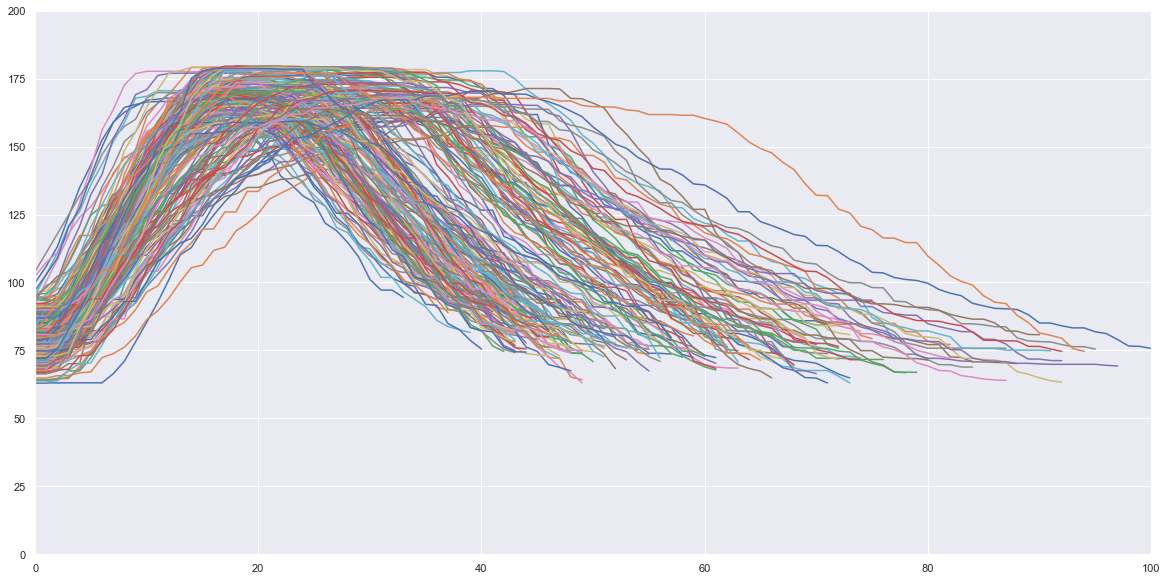

In [75]:
ax = None
plt.figure(figsize=(20, 10))
plt.xlim(0,100)
plt.ylim(0,200)
for ts in cluster2_df.Angle_array.values:
    #print(ts)
    ax = sns.lineplot(ax=ax,data=ts)
    
plt.show()


Testing K-Shape clustering

In [ ]:
from tslearn.cycc import cdist_normalized_cc, y_shifted_sbd_vec

def _shape_extraction(cluster, X, k):
        sz = X.shape[1]
        Xp = y_shifted_sbd_vec(cluster.cluster_centers_[k], X[self.labels_ == k],
                               norm_ref=-1,
                               norms_dataset=self.norms_[self.labels_ == k])
        S = numpy.dot(Xp[:, :, 0].T, Xp[:, :, 0])
        Q = numpy.eye(sz) - numpy.ones((sz, sz)) / sz
        M = numpy.dot(Q.T, numpy.dot(S, Q))
        _, vec = numpy.linalg.eigh(M)
        mu_k = vec[:, -1].reshape((sz, 1))

        # The way the optimization problem is (ill-)formulated, both mu_k and
        # -mu_k are candidates for barycenters
        # In the following, we check which one is best candidate
        dist_plus_mu = numpy.sum(numpy.linalg.norm(Xp - mu_k, axis=(1, 2)))
        dist_minus_mu = numpy.sum(numpy.linalg.norm(Xp + mu_k, axis=(1, 2)))
        if dist_minus_mu < dist_plus_mu:
            mu_k *= -1

        return mu_k


[13.15883021 13.15883021 12.67947314 12.11882352 12.08363213 12.06679984
 12.06640025 12.05049155 11.85554952 11.47254022 11.47254022 11.47254022
 11.46435742 11.30012102 11.15538455 10.70559121 10.29285236 10.27633222
 10.07363676 10.07363676 10.07363676 10.07363676 10.442466   10.442466
 10.442466   10.442466    9.65561022  9.58182613  9.58182613  9.58182613
  9.58182613  9.58571078 10.00351465 10.45987474 10.45987474 10.82257596
 10.88505463 10.88505463 10.88505463 10.88505463 10.88505463]
[13.67554574 13.67554574 13.67554574 13.67554574 13.6122301  12.00405486
 11.43739298 10.70514255  9.38121428  9.38121428  9.09131219  9.09131219
  9.38121428  9.72908333 10.42002058 10.42002058 10.42002058 10.42002058
  9.81845338  9.81845338  9.81845338 10.24989084 10.61577183 10.65865764
 10.89915109 10.89915109 10.89915109 10.89915109 10.20589292 10.20589292
 10.20589292 10.59826759 10.96205942 13.09171432 13.09171432 13.09171432
 12.61193224 12.61193224 12.61193224 12.61193224 12.61193224 12.

 10.25159409 10.24572338 10.24572338 10.24572338 10.24572338 12.48754013]
[12.48754013 12.44877366 11.67143972 11.46194759 10.33525781  9.32983752
  9.29551388  8.29446164  8.29446164  8.29446164  9.1807836   9.1807836
  9.1807836   6.31207707  6.31077749  6.10214003  6.02965009  6.02965009
  3.49163035  3.49163035  3.49163035  3.51933058  3.53257664  3.93848749
  4.33722294  4.43552154  5.18750349  6.24184633  6.31815688  6.62788904
  6.7603416   7.42973962  8.21198898  8.6452847   9.01428437  9.05248965
  9.05248965 10.25351497 11.53937418 11.85186483 12.14443648 12.33358034
 12.33358034 12.33358034 11.44135812 11.44135812 11.44135812 11.44135812
 11.44135812 11.44135812 11.29061078 11.21153185]
[12.83438409 12.83438409 13.36382075 13.36382075 13.36382075 11.61485973
 11.23776956  9.52435683  9.48787899  9.00475618  9.00475618  8.93532035
  8.93532035  8.93532035  8.93532035  8.93532035  8.87549345  8.87549345
  8.41707914  8.41707914  8.41707914  8.41707914  8.58531867  9.09909158
 

  9.00127214  9.00127214  9.00127214]
[12.07937396 12.07937396 12.07937396 11.49756548 10.81298711 10.45501441
 10.45501441 10.45501441 10.36623629  7.12527753  5.78134198  4.84150359
  4.8269774   4.40333612  3.64634662  3.64634662  3.64634662  5.30183144
  6.08439719  6.13442905  6.14404197  7.18394961  7.48059002  9.23925958
  9.61445846 10.16811018 10.29589554 10.47531354 10.62561323 10.62561323
 10.62561323  9.54526431  8.73919192  8.53326777  7.84115984  7.51715978
  7.50288625  7.50288625  7.50288625  7.50288625  7.84159802  9.21282282
 10.67449087 11.41210815 11.41210815]
[11.28931426 11.26485881 11.26462971 11.26462971  9.87745819  8.98413814
  8.89443533  8.27359788  8.27359788  8.27359788  8.27359788  8.27359788
  7.99568378  7.28933416  6.07551418  5.79402945  5.79359101  5.06068487
  4.3569188   4.189278    4.189278    4.189278    4.263855    5.51127978
  6.16711262  7.0812134   7.30070851  9.6941807   9.70804631  9.9718146
 10.33936534 11.5475454  11.5475454  11.5475454  

 12.36489439 12.98462152 12.98462152]
[12.98462152  9.94780884  8.27281999  7.21862811  6.92527833  6.92527833
  6.92527833  6.92527833  6.92527833  6.25593694  6.25593694  5.86295046
  5.86295046  5.26264476  4.40981707  4.40981707  4.40981707  6.28611319
  7.04609523  7.15548597  7.81177452  8.17164254  8.5183753   8.6746983
  8.96246553  8.96246553  8.96246553  8.96246553  8.96246553  9.10147116
  9.10147116  9.10147116  9.09756486  9.09756486  9.09756486  9.09756486
  9.09756486  9.09756486  9.06755893  9.06755893  9.06755893  9.06755893
  9.12449445]
[ 9.88201015 10.8341455  10.8341455  10.8341455   8.584645    6.87766348
  6.77034801  6.51556655  6.51556655  6.08984305  6.08984305  5.82618372
  4.52300503  3.613633    2.91373228  0.62007088  0.62007088  0.62007088
  1.32712576  2.95946775  3.76111076  5.41287549  7.67597956  8.15003046
  8.66257711  9.21129465  9.47889898  9.47889898 10.38047768 10.4643442
 10.79966891 11.02053338 11.02053338 11.02053338 11.02053338 11.02053338
 

 10.85030339 10.90997607 11.00797413 11.00797413 11.64276237]
[ 8.95863801  9.20245599  9.46412245  9.53938324 10.52099501 10.66225602
 10.66225602 10.77432566 10.77432566 10.77432566 10.77432566 10.77432566
 10.25408359  7.82986187  7.82986187  7.82986187  7.82986187  7.834496
  7.85200214  7.85200214  7.88884645  8.25077476  8.31238534  8.65072868
  8.65072868  8.65072868  8.65072868  8.96826138  8.96826138  8.96826138
  9.28274074  9.28274074  9.36906951  9.50615022  9.50615022  9.50615022
  9.76876367  9.76876367  9.76876367  9.76876367]
[12.1973646  12.41613539 12.41613539 12.41613539 12.41613539 11.3263161
  8.9235927   7.70923214  7.67801124  7.21137243  7.21137243  7.21137243
  7.21137243  7.58207727  7.71560589  7.71560589  7.73595117  8.09454628
  8.09454628  8.09454628  8.09454628  8.09454628  7.83757631  7.53523214
  7.53523214  7.44953232  7.44953232  7.44953232  8.95450998  8.95693653
  8.95719882  8.95719882  8.95719882  8.95693653  8.20585648  7.74500466
  6.94813911  6

 177.21672886 177.21672886 177.01040443]
[157.37129827 157.37129827 157.37129827 157.37129827 157.40872079
 157.94955612 158.39810769 158.84118862 161.57029096 161.57029096
 161.69930619 161.9923789  161.9923789  162.12940113 162.12940113
 162.12940113 162.12940113 162.2998395  163.20535314 163.20535314
 163.20535314 162.34582384 162.34582384 162.34582384 162.76390407
 162.76390407 162.76390407 161.79954608 161.79954608 161.6623612
 161.20905428 160.74154793 159.8358094  159.8358094  159.8358094
 159.8358094  159.8358094  159.78200193 159.78200193 159.78200193
 160.43080236 160.531387   160.531387   160.531387   160.1095815
 160.10162423 159.96359871]
[159.85207941 159.04876562 158.11928772 158.11928772 158.11928772
 158.50675315 158.79627095 158.79627095 158.79627095 158.73447673
 158.73447673 158.52645367 158.52645367 158.52645367 158.86061673
 158.86061673 158.86061673 158.60583405 158.60583405 158.60583405
 158.33794009 157.72337799 156.22464667 156.22464667 156.22464667
 157.29436

 179.55849534 179.55849534 179.55849534 178.12115192 178.01095373]
[177.48299718 177.48299718 178.01095373 178.09849072 178.98102764
 178.98102764 178.98102764 178.98102764 178.97945598 178.80534234
 178.80534234 178.80534234 178.80534234 179.11291027 179.21256647
 179.21256647 179.21256647 179.21256647 179.21256647 179.1490977
 179.00335364 179.00335364 178.97949291 178.97949291 178.97949291
 178.97949291 178.97949291 178.97949291 179.09539949 179.09539949
 179.09539949 179.09539949 179.08975136 179.07633545 179.07633545
 179.03682777 178.87133989 178.4787387  177.83215207 177.83215207
 177.83215207 177.83215207 178.61003113]
[178.94226189 179.23818827 179.32233708 179.4576412  179.4576412
 179.4576412  179.4576412  178.28495379 178.11822949 177.46623956
 177.46623956 177.27872316 177.27872316 177.27872316 177.71691677
 178.96433535 179.0504011  179.0504011  179.07110387 179.07110387
 179.07110387 179.07110387 179.07110387 179.03156121 179.07110387
 178.9882099  178.9882099  178.69815

 161.20933162 161.20933162 161.20933162 160.18654638 160.18058685]
[158.82148727 158.82148727 158.88531687 158.88531687 158.88531687
 158.877344   158.70522687 158.70522687 158.70522687 159.36686842
 159.56778648 160.3778081  160.46710316 160.46710316 160.46710316
 160.46710316 160.46710316 159.53225555 159.42447938 159.42447938
 159.42447938 159.59391258 159.59391258 159.59391258 159.59391258
 159.49140614 159.09130605 158.96718719 158.62765471 158.62765471
 158.62765471 159.45221184 159.45221184 159.45221184 159.45221184
 159.4767866  159.4767866  159.49051587 159.49051587 159.70697507
 160.10291895 160.18248089 160.20221017 160.83880485 160.83880485
 160.83880485 160.80088654 159.49217528]
[178.47660192 178.47660192 178.29060221 177.63557564 176.42163769
 176.42163769 176.42163769 176.42163769 177.38384869 177.86320326
 178.43287329 179.38678329 179.525399   179.525399   179.525399
 179.27853216 178.70133508 178.70133508 178.70133508 179.11674357
 179.23325306 179.23325306 179.23325

 178.9073891  179.02261305 179.02261305]
[179.34812852 179.34812852 178.86954067 178.81927803 177.7361212
 177.61986813 177.07804078 174.73899214 174.73899214 174.73899214
 174.73899214 174.73899214 175.09359265 176.24268412 178.82532823
 178.90047132 179.5005663  179.5005663  179.5005663  179.4962409
 179.36707316 178.49851357 176.49670152 176.06133131 173.57474863
 173.57474863 173.57474863 173.57474863 174.76195514 175.39310055
 175.56990694 176.03784277 176.35744968 176.35744968 178.53212227
 178.54131846 178.86391248 179.30730992 179.30730992 179.30730992
 179.30730992 178.84360343 178.84360343 178.84360343]
[179.020633   179.020633   179.020633   179.020633   179.37867655
 179.37867655 179.37867655 178.87145998 174.42678471 173.27703789
 173.26600417 173.26600417 173.26600417 176.6528457  176.83368629
 177.80256666 177.96870787 178.39799422 178.87191509 178.87191509
 178.87191509 178.87191509 179.07637192 179.07637192 179.08996002
 179.08996002 179.09579997 179.09579997 179.09579

 162.76256972 162.76256972]
[161.98807987 161.96359107 161.95092247 161.27948206 161.18679228
 160.39766467 160.37938433 160.37938433 160.37938433 160.39766467
 161.65764659 162.32205425 162.43455673 162.55753928 162.65927997
 162.65927997 162.65927997 160.67359859 160.67359859 160.67359859
 160.67359859 161.30354848 161.78027031 161.864818   161.88608207
 162.47928638 162.95672105 162.95672105 162.95672105 162.95672105
 162.95672105 162.90513769 162.76648369 162.76648369 162.71168613
 162.58911994 161.21137408 161.20914459 161.19135101 161.19135101
 161.19135101 161.21620936 162.00675266 162.06224718 162.06476466
 162.06476466 162.06476466 161.47420246 161.45732874]
[160.10453517 160.10453517 160.10453517 160.07960131 160.07960131
 160.07960131 160.07960131 160.42324202 161.14391714 161.82027107
 162.12376755 162.39263031 162.52273976 162.91098769 162.91098769
 162.98329666 162.98329666 162.98329666 163.11748501 163.67863725
 163.760389   164.06186916 164.06186916 164.06186916 163.538

 158.95592603 158.84039826 158.84039826]
[158.72722954 157.47534525 157.21736432 157.21736432 157.21736432
 157.21736432 157.39497611 157.40987002 157.94395315 158.03147933
 158.05735044 159.27957731 159.86781972 161.80952418 162.5048621
 162.5048621  162.76634769 162.76634769 162.76634769 162.76634769
 162.76634769 162.76634769 162.76634769 162.65062375 161.75641982
 161.23580507 161.23580507 161.23580507 161.35656562 161.35656562
 161.35656562 161.33941802 161.1431798  160.62988786 160.15238707
 160.05316915 158.97602943 158.87007614 158.35206002 158.35206002
 158.35206002 158.74226392 158.83334878 158.9544372  158.95909566
 159.04339438]
[159.04339438 159.04339438 158.91791135 158.82768771 158.1208681
 158.1208681  158.1208681  158.1208681  158.65895307 158.89652509
 159.51380421 159.59308938 161.21303565 161.21303565 162.22934805
 162.42579056 163.29484928 163.99304706 164.60571613 164.60571613
 164.60571613 164.42329351 163.35737394 163.32123309 162.89044605
 162.89044605 162.7207

 178.57427886]
[179.60526963 179.06675545 178.89844632 178.35285119 178.34429217
 178.11766947 177.96014105 177.57384279 177.43152263 177.43152263
 177.43152263 177.43152263 177.43152263 177.43152263 177.78759347
 177.88794969 177.88794969 179.52806326 179.52806326 179.52806326
 178.79343644 177.86481733 177.57992278 177.57992278 177.57992278
 177.57992278 177.57992278 177.93834423 177.93834423 177.97768003
 177.97768003 177.97768003 179.69086775 179.69086775 179.69086775
 179.69086775 178.47480151 178.47480151 178.47480151 178.50259081]
[178.97672753 179.4913701  179.4913701  179.4913701  178.90722222
 178.90722222 178.90722222 178.90722222 178.90722222 178.80960476
 177.82411585 177.82411585 177.35178347 177.35178347 177.35178347
 178.04301731 178.4381244  178.4381244  178.4381244  178.4381244
 178.4381244  178.53673987 178.53673987 178.53673987 178.53673987
 178.53673987 178.45817099 178.45817099 178.45817099 178.01949179
 178.01949179 178.01949179 178.01949179 178.56435119 179.0286

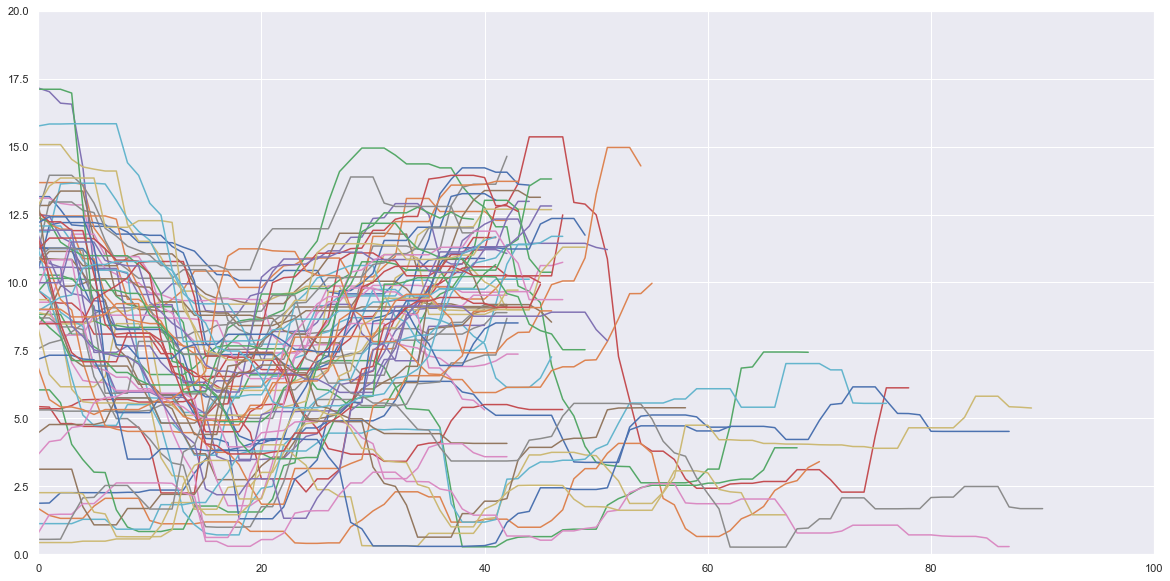

In [154]:
ax = None
plt.figure(figsize=(20, 10))
plt.xlim(0,100)
plt.ylim(0,20)
for ts in cluster0_df.Angle_array:
    print(ts)
    ax = sns.lineplot(ax=ax,data=ts)
    
plt.show()


# Timeseries Classification

In [17]:
from sklearn.model_selection import train_test_split
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

y = df['Label']
x = df['Angle_array']
#x = numpy_fillna(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(594,)
(255,)


In [18]:
k_range = range(1, 2) #26
scores = {}
scores_list = []
for k in k_range:
    knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw", n_jobs=-1)
    #knn_clf = KNeighborsClassifier(k, n_jobs=-1)
    knn_clf.fit(numpy_fillna(X_train.values), y_train)
    predicted_labels = knn_clf.predict(numpy_fillna(X_test.values))
    acc = metrics.accuracy_score(y_test, predicted_labels)
    scores[k] = acc
    print("Correct classification rate:", acc)
    print('\n')
    print(metrics.classification_report(y_test, predicted_labels))
    print(metrics.f1_score(y_test, predicted_labels, average='macro'))


Correct classification rate: 0.9372549019607843


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       174
           1       0.90      0.90      0.90        81

    accuracy                           0.94       255
   macro avg       0.93      0.93      0.93       255
weighted avg       0.94      0.94      0.94       255

0.9276287782034909


In [58]:
with open('datasets/triceps_df.pickle', 'wb') as f:
    pickle.dump(df, f)